# Filter fragments for unwanted substructures

## Aim of this notebook

This notebook aims to filter out fragments containing unwanted substructures, which could cause unwanted side effects. 
* One class of unwanted substructures are Pan Assay INterference compoundS (PAINS) ([ J. Med. Chem. 2010, 53, 7, 2719–2740](https://pubs.acs.org/doi/abs/10.1021/jm901137j)), which are included in the [rdkit Filter Catalog](https://www.rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html).
* We are also filtering for unwanted substructures according to the list of Brenk et al. ([ChemMedChem, 2008, 3(3),435--444](https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)).            

## Table of contents
1. Load fragment library
2. Apply pre-filters
3. Filter for PAINS substructures
4. Filter for substructures in list from Brenk et al.
5. Analyze accepted/rejected fragments

    5.1. Count number of fragments that are accepted by the filter(s)
    
    5.2. Highlight first Brenk structure found in the fragments

## Imports and preprocessing

In [2]:
from pathlib import Path

import pandas as pd
from rdkit.Chem import PandasTools
from IPython.core.display import HTML

from kinfraglib import filters, utils

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

### Define global paths

In [5]:
# Path to data
HERE = Path().resolve()
PATH_DATA = HERE / "../../data"
PATH_DATA_BRENK = HERE / "../../data/filters/Brenk"

## 1. Load fragment library

Fragment library is stored as a dictionary, with the individual subpockets as keys.

In [6]:
fragment_library_original = utils.read_fragment_library(PATH_DATA / "fragment_library")

In [7]:
fragment_library_original.keys()
# NBVAL_CHECK_OUTPUT

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [8]:
pd.concat(fragment_library_original).reset_index(drop=True).shape
# NBVAL_CHECK_OUTPUT

(7486, 15)

## 2. Apply pre-filters
Pre-filters include
- removing fragments in pool X
- removing duplicates
- removing fragments without dummy atoms (unfragmented ligands)
- removing fragments only connecting to pool X

In [9]:
fragment_library = filters.prefilters.pre_filters(fragment_library_original)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]"
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]"
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE]
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]"
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]"

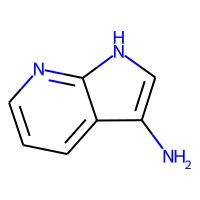
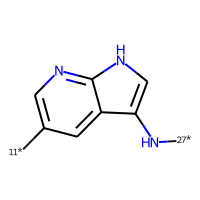
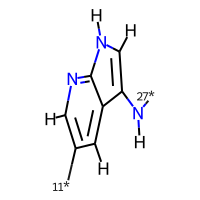
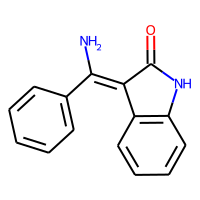
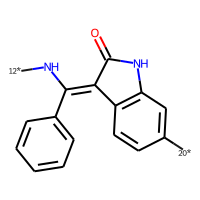
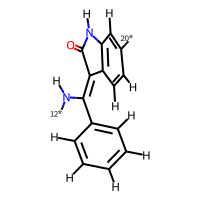
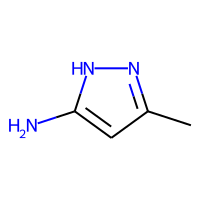
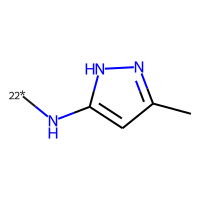
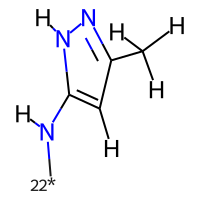
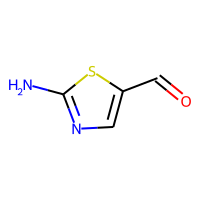
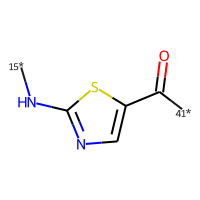
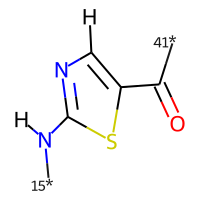
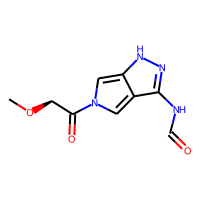
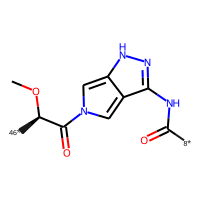
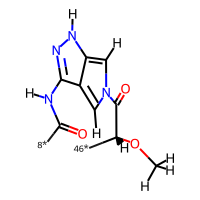

In [10]:
fragment_library["AP"].head()

Count number of fragments in the original fragment library and after pre-filtering the fragment library.

In [11]:
num_fragments = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library_original, "original"),
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
    ],
    axis=1,
)
num_fragments = pd.concat([num_fragments, num_fragments.sum().rename("Total").to_frame().T])
num_fragments
# NBVAL_CHECK_OUTPUT

,original,pre_filtered
AP,2561,1001
FP,1866,862
SE,1560,606
GA,1024,306
B1,98,42
B2,92,42
Total,7201,2859


Note: The number of fragments in pool X in the original fragment library is not displayed.

## 3. Filter for PAINS substructures

Pan Assay INterference compounds (PAINS) ([ J. Med. Chem. 2010, 53, 7, 2719–2740](https://pubs.acs.org/doi/abs/10.1021/jm901137j)) are substructural features which help to detect compounds that appear as false positive hits in high throughput screenings used as starting points for drug development.

In [12]:
filters.unwanted_substructures.get_pains?

Signature: filters.unwanted_substructures.get_pains(fragment_library)
Docstring:
Function to check fragments for PAINS structures.

Parameters
----------
fragment_library : dict
    fragments organized in subpockets including all information

Returns
-------
fragment_library, matches: tuple(dict,dict)
    Containing
        A dict containing a pandas.DataFrame for each subpocket with all fragments and an
        additional column (bool_pains) defining whether the fragment is accepted (1) or
        rejected (0).
        A pandas.DataFrame with the fragments and the names of the first PAINS structure found
        in the fragment.
File:      ~/KinFragLib/kinfraglib/filters/unwanted_substructures.py
Type:      function

In [13]:
fragment_library, pains_df = filters.unwanted_substructures.get_pains(fragment_library)

Inspect which PAINS structures were found per fragment (first match only).

Total number fragments with pains substructures: 42


,0,1,2,3,4
fragment,,,,,
pains,Imine_one_isatin(189),Imine_one_isatin(189),Imine_one_isatin(189),Quinone_a(370),Thio_ketone(43)

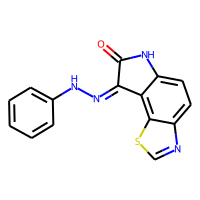
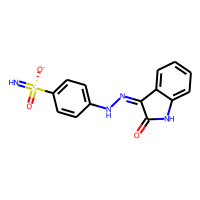
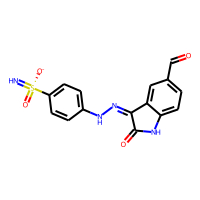
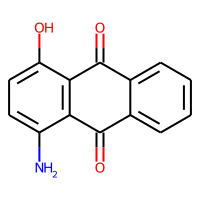
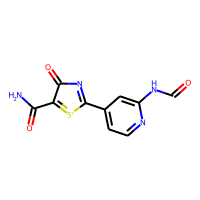

In [14]:
print(f"Total number fragments with pains substructures: {pains_df.shape[0]}")
HTML(pains_df.head().T.to_html(notebook=True))

Inspect individual subpockets, including the new column if a PAINS was found or not per fragment (`bool_pains`). 

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_pains
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",1
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",1

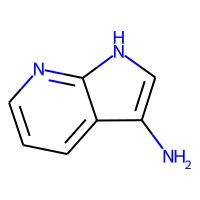
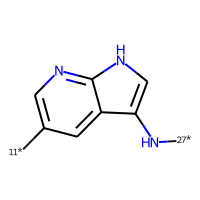
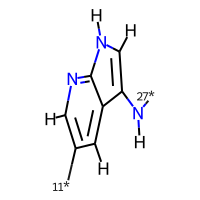
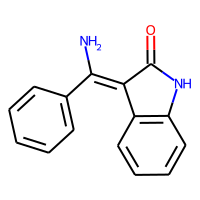
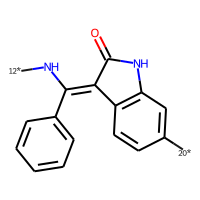
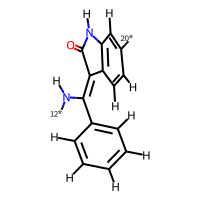
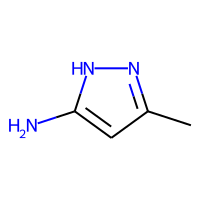
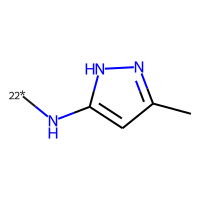
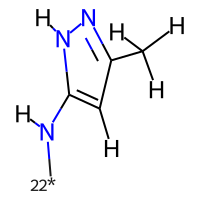
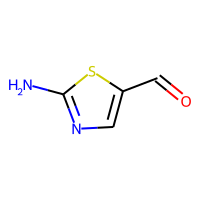
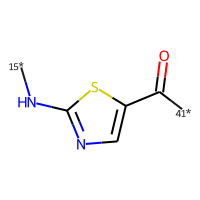
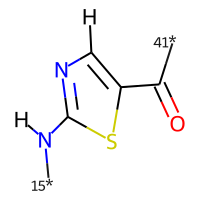
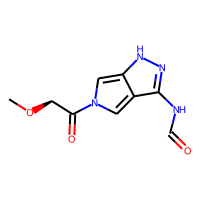
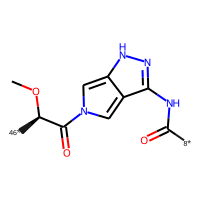
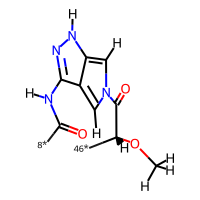

In [15]:
HTML(fragment_library["AP"].head().to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Count number of pre-filtered fragments and number of fragments that are accepted and rejected by the PAINS filter.

In [16]:
num_fragments_pains = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
        filters.analysis.count_accepted_rejected(
            fragment_library, "bool_pains", "pains"
        ),
    ],
    axis=1,
)
num_fragments_pains = pd.concat([num_fragments_pains, num_fragments_pains.sum().rename("Total").to_frame().T])
num_fragments_pains
# NBVAL_CHECK_OUTPUT

,pre_filtered,accepted_pains,rejected_pains
AP,1001,990,11
FP,862,845,17
SE,606,598,8
GA,306,300,6
B1,42,42,0
B2,42,42,0
Total,2859,2817,42


## 4. Filter for substructures in list from Brenk et al.

Brenk et al. ([ChemMedChem, 2008, 3(3),435--444](https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)) defined a list of substructures which can be used as selection criteria to enrich the libraries for lead-like compounds. 

Brenk et al. suggest to avoid using structures containing 
* potentially mutagenic groups (e.g. nitro groups), 
* groups with unfavorable pharmacokinetic properties (e.g. sulfates, phosphates), 
* reactive groups (e.g. 2-halopyridines, thiols) 
* and compounds typically interfering with HTS assays.         

In [17]:
filters.unwanted_substructures.get_brenk?

Signature: filters.unwanted_substructures.get_brenk(fragment_library, DATA)
Docstring:
Getting the path to the unwanted substructures provided by Brenk et al. and filtering them out.

Parameters
----------
fragment_library : dict
    fragments organized in subpockets including all information
DATA : str
    path to the csv file provided by Brenk et al.

Returns
-------
fragment_library, matches: tuple(dict,dict)
    Containing
        A dict containing a pandas.DataFrame for each subpocket with all fragments and an
        additional column (bool_brenk) defining wether the fragment is accepted (1) or
        rejected (0).
        A pandas.DataFrame with the fragments, the substructures found and the substructure
        names
File:      ~/KinFragLib/kinfraglib/filters/unwanted_substructures.py
Type:      function

In [18]:
fragment_library, brenk_structs = filters.unwanted_substructures.get_brenk(
    fragment_library, PATH_DATA_BRENK
)

Number of unwanted substructures in Brenk et al. collection: 104


Inspect which structures from Brenk list were found per fragment (first match only).

Total number fragments with brenk substructures: 797


,0,1,2,3,4
fragment,,,,,
substructure,,,,,
substructure_name,Michael-acceptor,stilbene,aldehyde,aldehyde,thiol

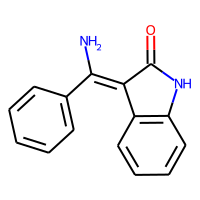
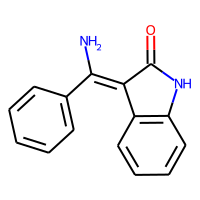
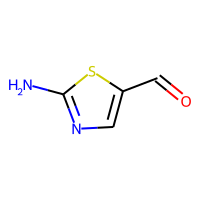
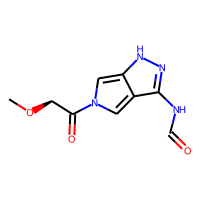
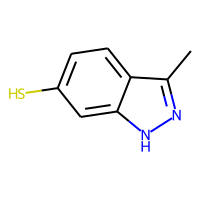
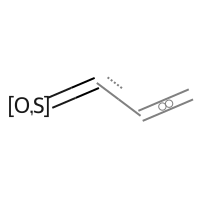
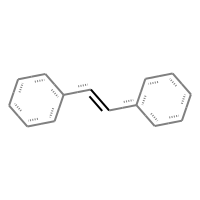
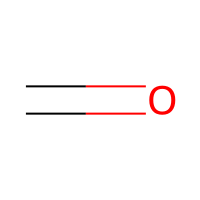
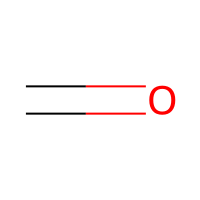
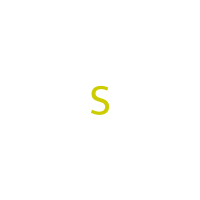

In [19]:
print(f"Total number fragments with brenk substructures: {brenk_structs.shape[0]}")
HTML(brenk_structs.head().T.to_html(notebook=True))

Inspect individual subpockets, including the new column if a Brenk substructure was found or not per fragment (`bool_brenk`). 

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_pains,bool_brenk
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1,1
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",1,0
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE],1,1
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]",1,0
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",1,0

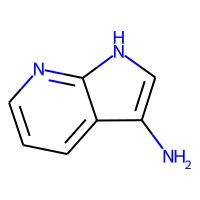
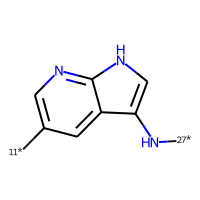
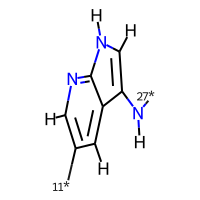
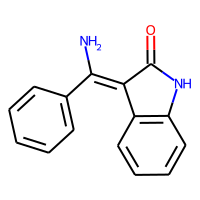
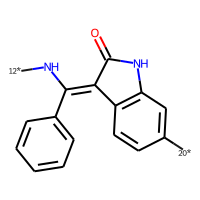
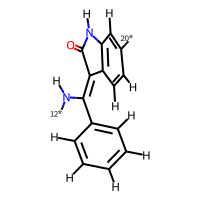
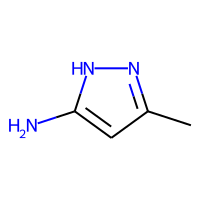
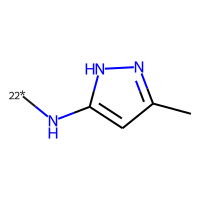
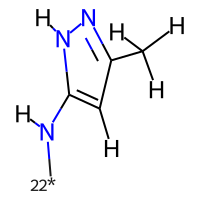
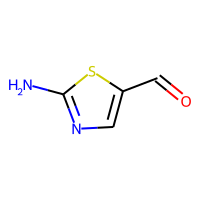
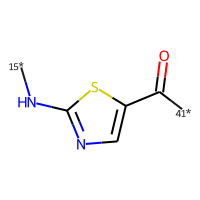
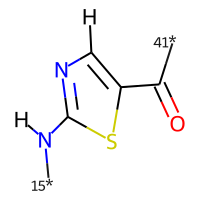
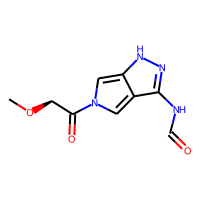
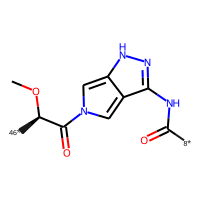
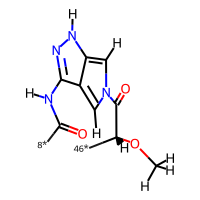

In [20]:
HTML(fragment_library["AP"].head().to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

Count number of pre-filtered fragments and number of fragments that are accepted and rejected by the Brenk et al. filter.

In [21]:
num_fragments_brenk = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
        filters.analysis.count_accepted_rejected(
            fragment_library, "bool_brenk", "brenk"
        ),
    ],
    axis=1,
)
num_fragments_brenk = pd.concat([num_fragments_brenk, num_fragments_brenk.sum().rename("Total").to_frame().T])
num_fragments_brenk
# NBVAL_CHECK_OUTPUT

,pre_filtered,accepted_brenk,rejected_brenk
AP,1001,782,219
FP,862,705,157
SE,606,496,110
GA,306,196,110
B1,42,26,16
B2,42,36,6
Total,2859,2241,618


## 5. Analyze accepted/rejected fragments

    5.1. Count number of fragments that are accepted by the filter(s).
    
    5.2. Highlight first Brenk structure found in the fragments

### 5.1. Count number of fragments that are accepted by the filter(s)

In [22]:
fragment_library = filters.analysis.number_of_accepted(
    fragment_library, columns=["bool_pains", "bool_brenk"], min_accepted=2
)

In [23]:
filters.analysis.accepted_num_filters(
    fragment_library,
    ["bool_pains", "bool_brenk"],
    filtername="unwanted substrutcures filters",
    max_num_accepted=2,
)

,pre-filtered,accepted by 2,accepted by 1,accepted by 0
AP,1001,781,210,10
FP,862,702,146,14
SE,606,494,106,6
GA,306,195,106,5
B1,42,26,16,0
B2,42,36,6,0
Total,2859,2234,590,35


### 5.2. Highlight first Brenk structure found in the fragments

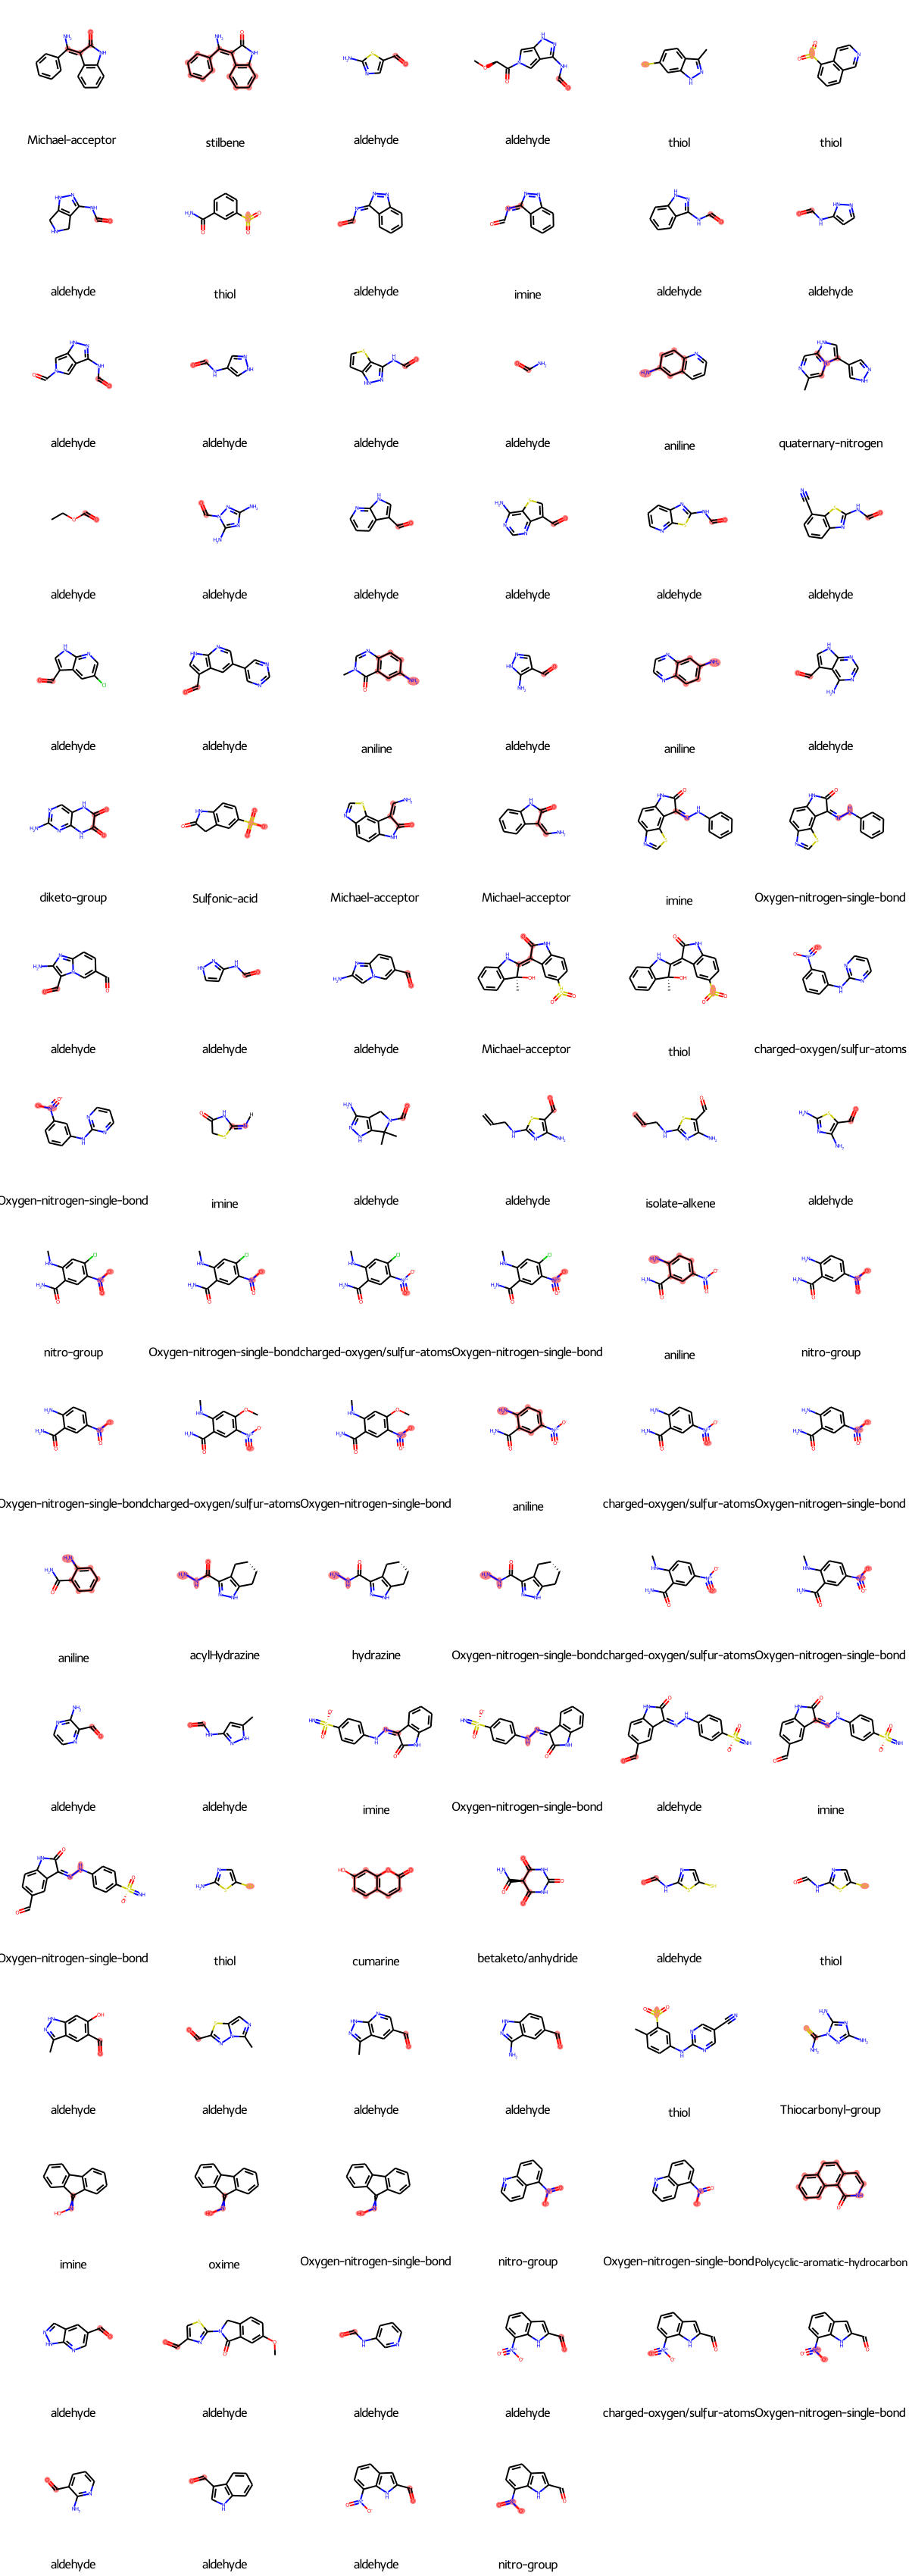

In [24]:
from rdkit import Chem
to_highlight = [
    row.fragment.GetSubstructMatch(row.substructure) for _, row in brenk_structs.iterrows()
]
Chem.Draw.MolsToGridImage(
    list(brenk_structs.fragment)[:100],
    highlightAtomLists=to_highlight,
    legends=list(brenk_structs.substructure_name),
    molsPerRow=6,
    maxMols=100,
)